# Exploratory Data Analysis
Link to the project: drinkability of water 
[(fr)](https://drive.google.com/file/d/1FGNR1O8EKGVKpVB_PMb5Ty2LipYgoM8q/view?usp=sharing)
[(kaggle)](https://www.kaggle.com/artimule/drinking-water-probability)

In this notebook, we will try to explore and better understand the distribution of our data.\
This will be used to do some preprocessing.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Load the data

In [2]:
try:
    from google.colab import drive

    IN_COLAB = True
    drive.mount('/content/drive')
except:
    IN_COLAB = False

In [3]:
if IN_COLAB:
    path = "/content/drive/MyDrive/Best ML model ever/input/drinking_water_potability.csv"
else:
    path = "../input/raw/drinking_water_potability.csv"

df = pd.read_csv(path)
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
nb_tot_rows = df.shape[0]
df_features = df.drop("Potability", axis=1)
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,6.063355,160.767311,14775.14560,7.484104,305.828553,327.270239,12.309016,69.038454,3.467337,0
1,NaN,233.020134,27071.11862,6.220936,298.112645,357.119622,16.768945,51.284400,4.284879,0
2,9.252857,168.040751,50279.26243,5.905056,415.450810,400.003589,11.949854,62.256881,3.300586,0
3,3.989032,216.076138,40175.20609,7.487423,309.800796,399.047181,11.186739,86.957464,4.409414,0
4,9.454119,224.817132,21379.96393,5.407692,227.665635,431.613001,15.772334,52.033845,4.058626,1


## Data exploration

### Feature types and null values

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


All values are continuous (except for the labels _Potability_, which is 0 or 1).

There are some null values in:
- **ph category** (for 491 rows)
- **Sufate category** (for 781 rows)
- **Trihalomethanes category** (for 162 rows)

### Analysis from knowledge on subject

According to WHO:
- **pH** of drinkable water should be between 6.5 and 8.5
- **Solids** should be between 500 mg/L and 1000 mg/L (another scale is used here)
- **Chloramines** should be below 4 mg/L (another scale is used here)
- **Sulfate** should be approx. 3 to 30 mg/L (*100 here)
- **Conductivity** should be below 400 microS/cm
- **Organic carbon** is usually lower than 4 mg/L (another scale is used here)
- **Trihalomethanes** should be lower than 80 microg/L
- **Turbidity** should be lower than 5

In [5]:
df_features[df["Potability"] == 1].describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
count,1101.000000,1278.000000,1278.000000,1278.000000,985.000000,1278.000000,1278.000000,1223.000000,1278.000000
mean,7.073783,195.800744,22383.991018,7.169338,332.566990,425.383800,14.160893,66.539684,3.968328
std,1.448048,35.547041,9101.010208,1.702988,47.692818,82.048446,3.263907,16.327419,0.780842
min,0.227499,47.432000,728.750830,0.352000,129.000000,201.619737,2.200000,8.175876,1.492207
25%,6.179312,174.330531,15668.985038,6.094134,300.763772,360.939023,12.033897,56.014249,3.430909
50%,7.036752,196.632907,21199.386615,7.215163,331.838167,420.712729,14.162809,66.678214,3.958576
75%,7.933068,218.003420,27973.236447,8.199261,365.941346,484.155911,16.356245,77.380975,4.509569
max,13.175402,323.124000,56488.672410,13.127000,481.030642,695.369528,23.604298,124.000000,6.494249


We can clearly see here that some water labeled as drinkable shouldn't be:
- very low pHs for some of them
- conductivity too high for some
- triholomethanes too high for some
- turbidity too high for some

We can try to filter them out:

In [6]:
df_corrected_hard = df[(df["Potability"] == 0) | 
                        ((df_features["ph"] >= 6.5) & (df_features["ph"] <= 8.5) &
                        (df_features["Conductivity"] <= 400) &
                        (df_features["Trihalomethanes"] <= 80) &
                        (df_features["Turbidity"] <= 5))].reset_index(drop=True)
df_corrected_hard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               1853 non-null   float64
 1   Hardness         2167 non-null   float64
 2   Solids           2167 non-null   float64
 3   Chloramines      2167 non-null   float64
 4   Sulfate          1643 non-null   float64
 5   Conductivity     2167 non-null   float64
 6   Organic_carbon   2167 non-null   float64
 7   Trihalomethanes  2060 non-null   float64
 8   Turbidity        2167 non-null   float64
 9   Potability       2167 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 169.4 KB


0    1998
1     169
Name: Potability, dtype: int64

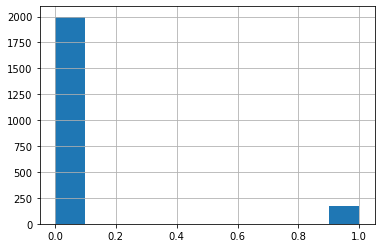

In [7]:
df_corrected_hard["Potability"].hist()
df_corrected_hard["Potability"].value_counts()

We see here that the majority of the data concerning drinkable water were deleted (especially due to Conductivity, for which more than 50% of all the values were filtered out; only 8% of the data has a positive label).

We can try to find other sources for these limits: 
- pH can be greater, up to 9.5, and lower pH aren't direclty dangerous for humans but bacteries are more prone to grow there (then we can lower its limit a bit, to 6 for example)
- Some drinkable water seem to have a conductivity up to 800 microS/cm according to some studies (e.g. [Sensorex](https://sensorex.com/blog/2017/07/12/conductivity-monitoring-reverse-osmosis/))
- Trihalomethane level is up to 100 ppm in Europe/Canada, so we may raise it to 200 ppm to be sure (and then not even filter it)

Let's try again:

In [8]:
df_corrected = df[(df["Potability"] == 0) | 
                    ((df_features["ph"] >= 6) & (df_features["ph"] <= 9.5) &
                    (df_features["Conductivity"] <= 800) &
                    (df_features["Turbidity"] <= 5))].reset_index(drop=True)
df_features_corrected = df_corrected.drop("Potability", axis=1)
df_corrected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2422 non-null   float64
 1   Hardness         2736 non-null   float64
 2   Solids           2736 non-null   float64
 3   Chloramines      2736 non-null   float64
 4   Sulfate          2078 non-null   float64
 5   Conductivity     2736 non-null   float64
 6   Organic_carbon   2736 non-null   float64
 7   Trihalomethanes  2594 non-null   float64
 8   Turbidity        2736 non-null   float64
 9   Potability       2736 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 213.9 KB


0    1998
1     738
Name: Potability, dtype: int64

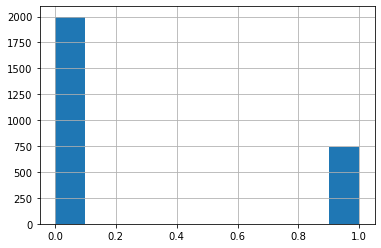

In [9]:
df_corrected["Potability"].hist()
df_corrected["Potability"].value_counts()

It's better but we still lose many examples (now only 25% of the data has positive labels).

Instead of deleting thoses values, we could fix them to Q1 or Q3.

### Balanced dataset

0    1998
1    1278
Name: Potability, dtype: int64

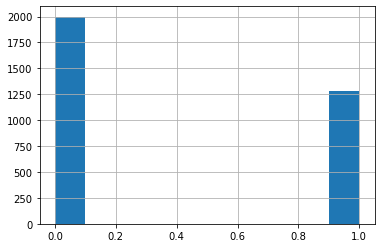

In [10]:
df["Potability"].hist()
df["Potability"].value_counts()

61% of the examples have a negative label (undrinkable water)\
39% of the examples have a positive label (drinkable water)

This dataset is slighlty skewed and thus the best metric for this binary classification problem would be Area Under the ROC Curve (AUC). We can use precision and recall too, but AUC combines these two metrics. Thus, we will be using AUC to evaluate the model that we build on this dataset.

### Scaling

In [11]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690300,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833605,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762125,8.114887,359.950170,481.792305,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196010,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


We will have to scale the features as their means and variances are quite different.

For features with huge variance (e.g. Solids), we can try to use a power transform.

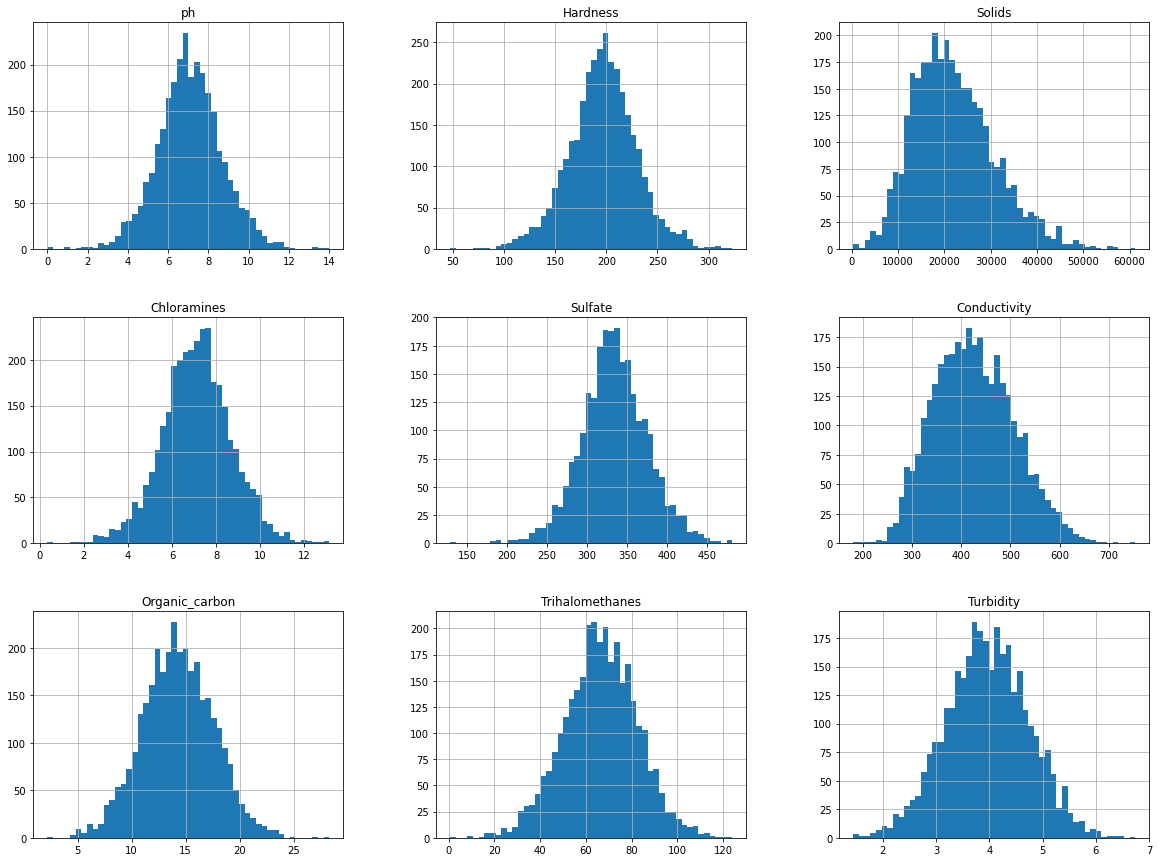

In [12]:
df_features.hist(bins=50, figsize=(20, 15))
plt.show()

All values seem to follow Gaussian distributions, and feature seems to be capped.

### Correlations

#### Between the features

In [13]:
df_features.corr()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
ph,1.000000,0.082096,-0.089288,-0.034350,0.018203,0.018614,0.043503,0.003354,-0.039057
Hardness,0.082096,1.000000,-0.046899,-0.030054,-0.106923,-0.023915,0.003610,-0.013013,-0.014449
Solids,-0.089288,-0.046899,1.000000,-0.070148,-0.171804,0.013831,0.010242,-0.009143,0.019546
Chloramines,-0.034350,-0.030054,-0.070148,1.000000,0.027244,-0.020486,-0.012653,0.017084,0.002363
Sulfate,0.018203,-0.106923,-0.171804,0.027244,1.000000,-0.016121,0.030831,-0.030274,-0.011187
Conductivity,0.018614,-0.023915,0.013831,-0.020486,-0.016121,1.000000,0.020966,0.001285,0.005798
Organic_carbon,0.043503,0.003610,0.010242,-0.012653,0.030831,0.020966,1.000000,-0.013274,-0.027308
Trihalomethanes,0.003354,-0.013013,-0.009143,0.017084,-0.030274,0.001285,-0.013274,1.000000,-0.022145
Turbidity,-0.039057,-0.014449,0.019546,0.002363,-0.011187,0.005798,-0.027308,-0.022145,1.000000


<AxesSubplot:>

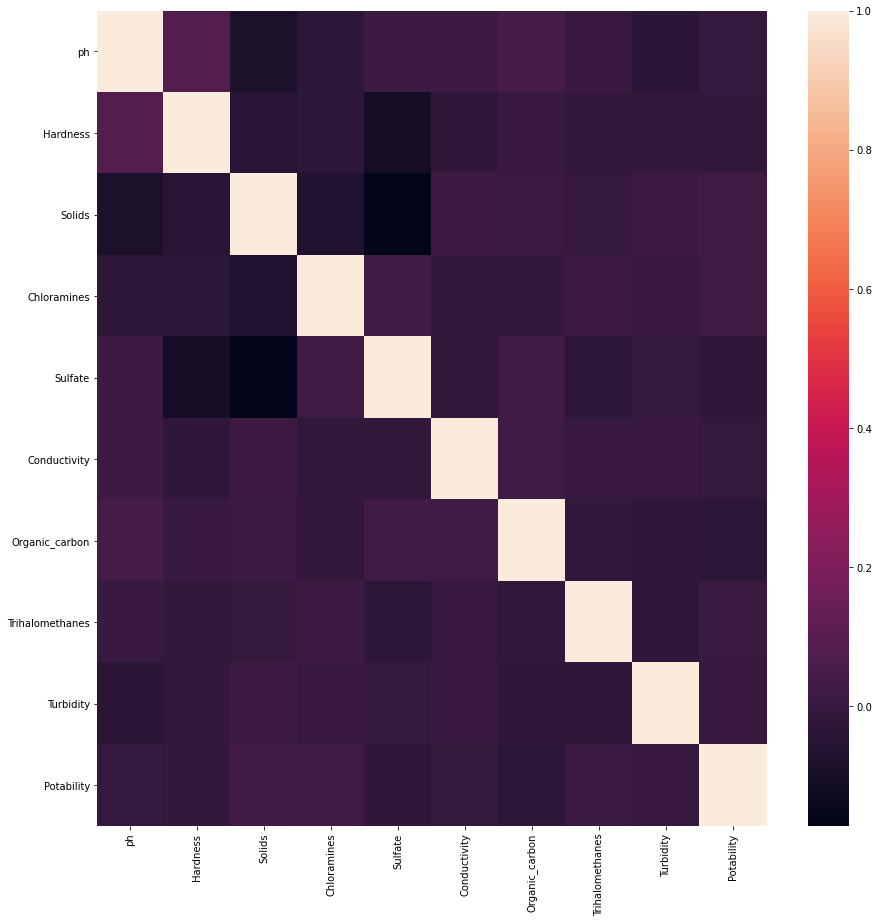

In [14]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(corr, 
  xticklabels=corr.columns,
  yticklabels=corr.columns,
  ax=ax)

Only very weak correlations

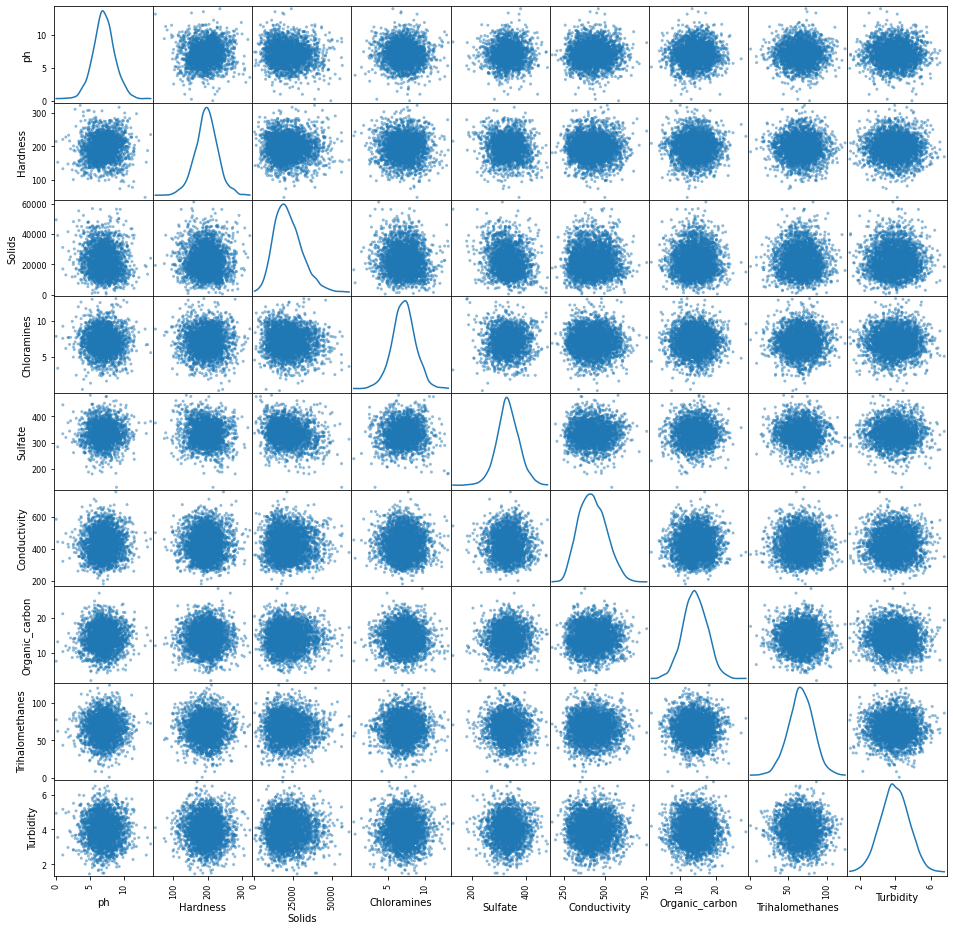

In [15]:
from pandas.plotting import scatter_matrix

scatter_matrix(df_features, figsize=(16, 16), diagonal="kde");

#### Between features and labels

In [16]:
df.corr()["Potability"].sort_values(ascending=False)

Potability         1.000000
Solids             0.033743
Chloramines        0.023779
Trihalomethanes    0.007130
Turbidity          0.001581
ph                -0.003556
Conductivity      -0.008128
Hardness          -0.013837
Sulfate           -0.023577
Organic_carbon    -0.030001
Name: Potability, dtype: float64

No strong correlation with any of the features.

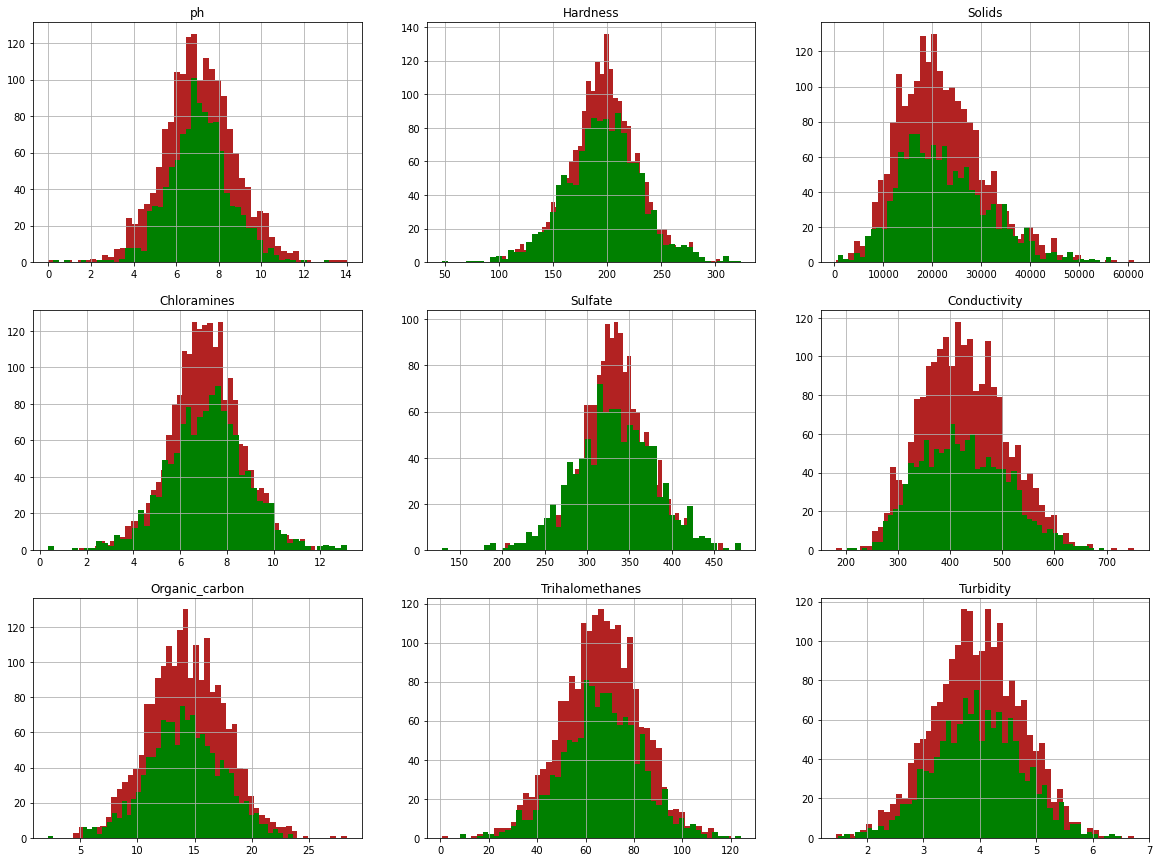

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=3)
for i, name in enumerate(df_features.columns):
  df_features[df["Potability"] == 0][name].hist(bins=50, ax=axes[i//3][i%3], figsize=(20, 15), color='firebrick')
  df_features[df["Potability"] == 1][name].hist(bins=50, ax=axes[i//3][i%3], figsize=(20, 15), color='g')
  axes[i//3][i%3].set_title(name)

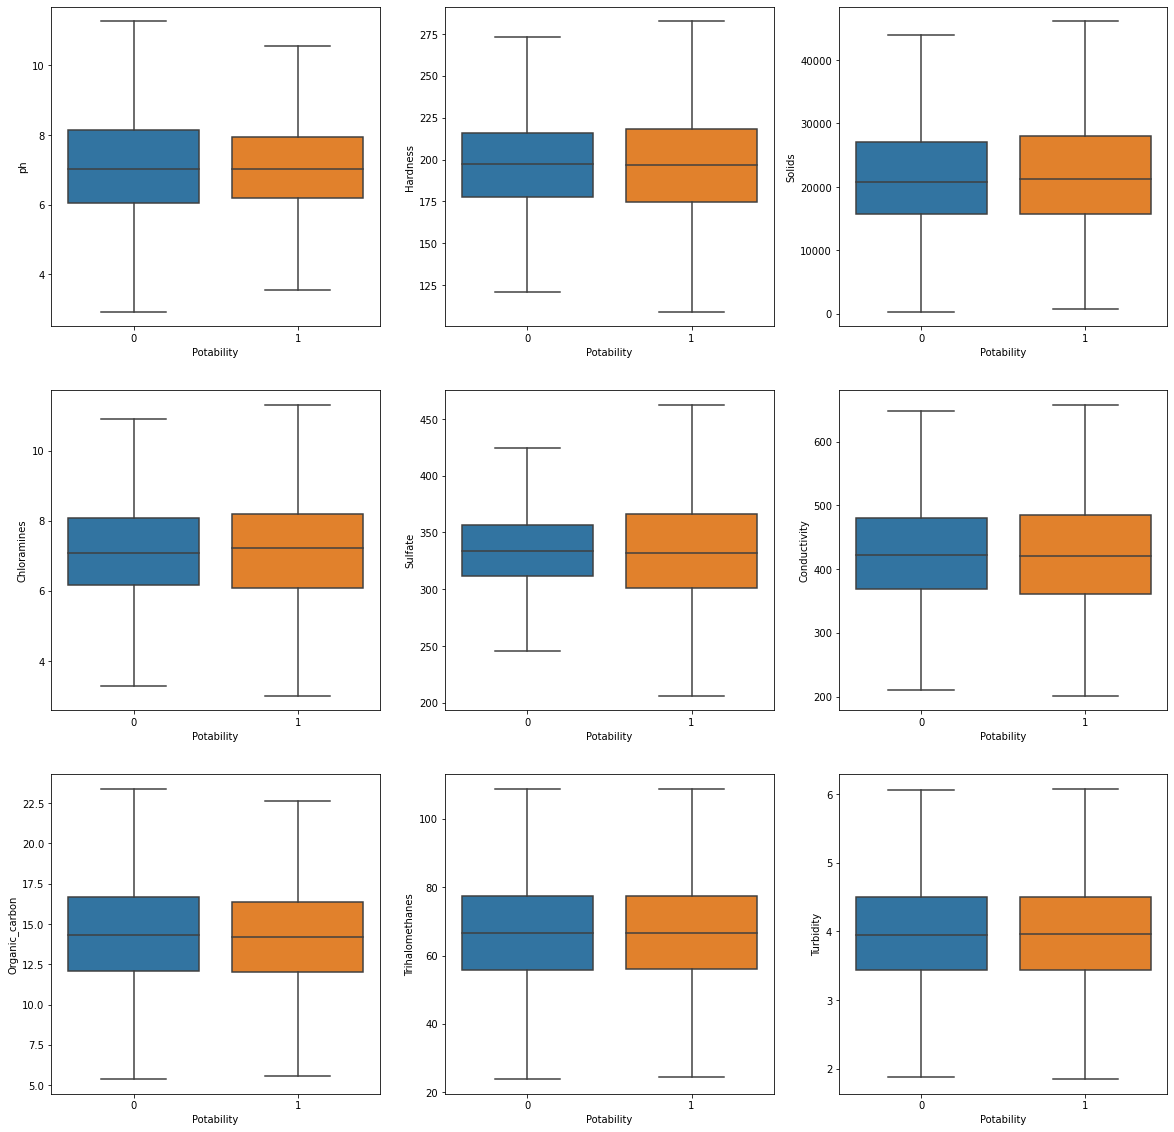

In [18]:
columns = df_features.columns
plt.figure(figsize=(20,20))
for i in range(9):
    plt.subplot(3,3,i+1)
    sns.boxplot(data=df, x = 'Potability', y= columns[i], showfliers=False)

In [19]:
new_dfs = []
for name in df_features.columns:
  n_pot = df_features[df["Potability"] == 0][name].describe()
  pot = df_features[df["Potability"] == 1][name].describe()
  new_dfs.append(pd.concat([n_pot,pot], axis=1, keys=["{} for p=0".format(name), "{} for p=1".format(name)]))
full_df = pd.concat(new_dfs, axis=1)
full_df

,ph for p=0,ph for p=1,Hardness for p=0,Hardness for p=1,Solids for p=0,Solids for p=1,Chloramines for p=0,Chloramines for p=1,Sulfate for p=0,Sulfate for p=1,Conductivity for p=0,Conductivity for p=1,Organic_carbon for p=0,Organic_carbon for p=1,Trihalomethanes for p=0,Trihalomethanes for p=1,Turbidity for p=0,Turbidity for p=1
count,1684.000000,1101.000000,1998.000000,1278.000000,1998.000000,1278.000000,1998.000000,1278.000000,1510.000000,985.000000,1998.000000,1278.000000,1998.000000,1278.000000,1891.000000,1223.000000,1998.000000,1278.000000
mean,7.085378,7.073783,196.733292,195.800744,21777.490788,22383.991018,7.092175,7.169338,334.564290,332.566990,426.730454,425.383800,14.364335,14.160893,66.303555,66.539684,3.965800,3.968328
std,1.683499,1.448048,31.057540,35.547041,8543.068788,9101.010208,1.501045,1.702988,36.745549,47.692818,80.047317,82.048446,3.334554,3.263907,16.079320,16.327419,0.780282,0.780842
min,0.000000,0.227499,98.452931,47.432000,320.942611,728.750830,1.683993,0.352000,203.444521,129.000000,181.483754,201.619737,4.371899,2.200000,0.738000,8.175876,1.450000,1.492207
25%,6.037723,6.179312,177.823265,174.330531,15663.057382,15668.985038,6.155640,6.094134,311.264006,300.763772,368.498530,360.939023,12.101057,12.033897,55.706530,56.014249,3.444062,3.430909
50%,7.035456,7.036752,197.123423,196.632907,20809.618280,21199.386615,7.090334,7.215163,333.389426,331.838167,422.229331,420.712729,14.293508,14.162809,66.542198,66.678214,3.948076,3.958576
75%,8.155510,7.933068,216.120687,218.003420,27006.249013,27973.236447,8.066462,8.199261,356.853897,365.941346,480.677198,484.155911,16.649485,16.356245,77.277704,77.380975,4.496106,4.509569
max,14.000000,13.175402,304.235912,323.124000,61227.196010,56488.672410,12.653362,13.127000,460.107069,481.030642,753.342620,695.369528,28.300000,23.604298,120.030077,124.000000,6.739000,6.494249


Correlations between each feature and labels also seams to be weak.

### Detection of outliers

In [65]:
def show_outliers(df_features):
    series_outliers = []
    for name in df_features.columns:
        series_feature = df_features[name]
        stats = series_feature.describe()
        iqr = stats["75%"] - stats["25%"]
        lower_boundary = stats["25%"] - 1.5*iqr
        higher_boundary = stats["75%"] + 1.5*iqr
        nb_tot = series_feature.count()
        nb_low = series_feature[series_feature<lower_boundary].count()
        nb_high = series_feature[series_feature>higher_boundary].count()
        pc_outliers = (nb_low+nb_high)/nb_tot_rows
        series_feature_outliers = pd.Series([nb_tot, nb_low, nb_high, pc_outliers], index=["count", "low outliers", "high outliers", "%outliers"], name=name)
        series_outliers.append(series_feature_outliers)
    df_outliers_stats = pd.concat(series_outliers, axis=1)
    return df_outliers_stats

In [21]:
df_outliers_stats = show_outliers(df_features)
df_outliers_stats

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
count,2785.000000,3276.000000,3276.000000,3276.00000,2495.000000,3276.000000,3276.000000,3114.000000,3276.0000
low outliers,21.000000,44.000000,0.000000,31.00000,21.000000,1.000000,13.000000,19.000000,10.0000
high outliers,25.000000,39.000000,47.000000,30.00000,20.000000,10.000000,12.000000,14.000000,9.0000
%outliers,0.014042,0.025336,0.014347,0.01862,0.012515,0.003358,0.007631,0.010073,0.0058


In [22]:
show_outliers(df_features_corrected)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
count,2422.000000,2736.000000,2736.000000,2736.000000,2078.000000,2736.000000,2736.000000,2594.000000,2736.000000
low outliers,30.000000,36.000000,0.000000,31.000000,20.000000,1.000000,11.000000,14.000000,9.000000
high outliers,28.000000,31.000000,39.000000,27.000000,21.000000,9.000000,9.000000,12.000000,8.000000
%outliers,0.017705,0.020452,0.011905,0.017705,0.012515,0.003053,0.006105,0.007937,0.005189


Same distribution for both dataframes (filtered and not filtered): the outliers we saw before don't represent the majority.

#### Stats of outliers

We can compare some stats for outliers:

In [23]:
boundaries = {}

for name in df_features.columns:
    series_feature = df_features[name]
    stats = series_feature.describe()
    iqr = stats["75%"] - stats["25%"]
    lower_boundary = stats["25%"] - 1.5*iqr
    higher_boundary = stats["75%"] + 1.5*iqr
    boundaries[name] = (lower_boundary, higher_boundary)

In [24]:
def show_stat_outliers(stat):
  series_outliers = []

  for name_i in df_features.columns:
    lower_i, higher_i = boundaries[name_i]
    df_stats_i = df_features[(df_features[name_i] < lower_i) | (df_features[name_i] > higher_i)].describe()
    series_outliers.append(df_stats_i.loc[stat, :].rename("{} outliers".format(name_i)))
  return pd.concat(series_outliers, axis=1)

In [25]:
show_stat_outliers("mean")

,ph outliers,Hardness outliers,Solids outliers,Chloramines outliers,Sulfate outliers,Conductivity outliers,Organic_carbon outliers,Trihalomethanes outliers,Turbidity outliers
ph,7.362907,7.380921,6.584905,7.276427,6.952881,7.004659,7.016245,7.162141,6.730824
Hardness,186.674410,191.056858,194.214812,196.733117,193.026641,207.481884,198.357756,198.831954,186.996842
Solids,24264.106754,24808.399702,48803.519834,22256.426280,23675.822489,22159.127014,20277.504052,19683.128916,23995.254283
Chloramines,7.255440,7.032646,6.744863,7.081920,7.823755,7.168513,7.388810,7.227565,6.641311
Sulfate,338.323008,344.442447,309.706440,328.609282,325.672303,332.219394,326.302301,331.138891,320.540946
Conductivity,431.603856,430.227623,437.136244,420.771992,432.240047,636.053449,417.129084,413.377390,421.257749
Organic_carbon,13.941844,13.465599,14.181977,13.731349,13.874959,14.707539,14.150077,14.119262,14.451363
Trihalomethanes,65.962902,68.965296,68.986300,62.327091,65.582388,70.276773,68.727851,58.292102,61.848959
Turbidity,3.956003,3.897872,3.874283,3.950167,4.087486,3.956631,4.004016,4.041641,3.888388


In [26]:
show_stat_outliers("std")

,ph outliers,Hardness outliers,Solids outliers,Chloramines outliers,Sulfate outliers,Conductivity outliers,Organic_carbon outliers,Trihalomethanes outliers,Turbidity outliers
ph,4.945739,2.446821,2.420129,1.949457,1.830142,1.901819,1.565487,1.645422,1.045356
Hardness,53.007693,92.856795,43.934051,40.821663,47.046671,46.743870,40.831702,32.904319,25.768475
Solids,12309.340055,10390.179096,3962.388717,10111.379202,13834.909159,8226.687159,7658.663962,8549.926919,9682.747782
Chloramines,1.762840,1.902442,1.894165,4.765701,2.623174,1.108034,2.080800,1.580624,1.650966
Sulfate,46.470404,56.183590,61.213905,62.720547,126.725004,39.083776,54.170911,42.389157,36.844798
Conductivity,67.676929,79.193721,79.466020,79.925128,75.240247,153.453798,67.457749,71.547579,74.333871
Organic_carbon,3.364502,3.465490,3.252111,3.144287,3.448074,3.599521,10.092069,3.294049,3.676792
Trihalomethanes,16.127849,15.306207,14.774664,13.813883,13.616518,11.791912,14.752311,49.116816,17.733476
Turbidity,0.906002,0.717133,0.809762,0.870806,0.818283,0.758480,0.712476,0.687901,2.422370


In [27]:
show_stat_outliers("25%")

,ph outliers,Hardness outliers,Solids outliers,Chloramines outliers,Sulfate outliers,Conductivity outliers,Organic_carbon outliers,Trihalomethanes outliers,Turbidity outliers
ph,2.560888,5.324942,4.771491,6.256651,5.701154,5.771146,6.037348,6.253687,6.117187
Hardness,151.969707,108.807853,157.343787,160.496448,155.262609,180.589953,175.873676,184.066169,168.817047
Solids,14394.177317,17092.563330,45380.016675,15924.799690,13677.994040,16647.493790,16679.335160,14841.242000,18833.744455
Chloramines,6.409418,5.725595,5.720307,2.648390,5.829424,6.420352,6.029670,6.029670,5.373634
Sulfate,312.054239,314.628471,271.098439,296.303872,209.471058,309.500051,298.041354,303.556807,288.171706
Conductivity,382.981404,373.863418,375.247604,360.814296,376.456593,658.912684,358.185473,367.897563,353.415979
Organic_carbon,11.503595,11.590547,12.521013,11.930433,11.384858,12.368347,4.966862,12.182639,11.870802
Trihalomethanes,55.443307,60.249306,58.619101,51.447043,53.893077,63.512441,65.954766,17.915723,46.043855
Turbidity,3.205641,3.444098,3.289933,3.377451,3.577447,3.540488,3.542093,3.687995,1.670177


In [28]:
show_stat_outliers("50%")

,ph outliers,Hardness outliers,Solids outliers,Chloramines outliers,Sulfate outliers,Conductivity outliers,Organic_carbon outliers,Trihalomethanes outliers,Turbidity outliers
ph,11.124870,7.480728,6.825468,7.457165,6.891888,6.983133,6.418907,7.058866,6.808601
Hardness,188.205459,116.725122,196.024255,201.938643,195.540967,190.992873,202.817483,197.541072,182.999381
Solids,20594.680790,24244.111960,48002.084600,20555.965490,21379.963930,20567.145930,19214.186360,18608.656300,24538.437290
Chloramines,7.466708,7.050503,6.651801,3.139553,8.045870,6.931628,7.153803,7.411035,7.258722
Sulfate,332.744519,338.773772,306.920206,330.192578,227.665635,343.047384,327.860029,327.650542,323.758045
Conductivity,431.611220,422.318227,422.318227,415.629484,435.418245,669.725086,412.709423,409.220776,426.103715
Organic_carbon,14.022130,13.425165,14.225917,13.755926,14.156241,15.752252,5.315287,12.942291,15.122672
Trihalomethanes,66.539884,69.646822,69.895440,65.145585,67.333687,69.195926,71.833624,22.749735,64.676414
Turbidity,3.825976,3.895572,3.936973,4.014682,4.147169,3.592496,3.864931,3.983099,1.844372


In [29]:
show_stat_outliers("75%")

,ph outliers,Hardness outliers,Solids outliers,Chloramines outliers,Sulfate outliers,Conductivity outliers,Organic_carbon outliers,Trihalomethanes outliers,Turbidity outliers
ph,11.496820,9.318614,8.436759,8.550525,8.236381,8.305098,7.608837,8.283096,7.423883
Hardness,225.724630,281.588199,225.197834,229.263861,234.893703,242.317928,213.691169,217.369746,207.280259
Solids,34541.966207,28848.702220,50222.897875,28652.143300,32018.289630,24251.370600,21759.363930,24789.354730,28304.205265
Chloramines,8.504780,8.373791,7.895813,11.586151,9.840949,7.882730,8.832138,8.435789,7.695036
Sulfate,375.894758,380.808786,349.604181,368.673528,446.724016,361.853829,351.785338,346.894894,344.566890
Conductivity,472.182616,492.386371,489.593090,460.146174,480.848064,684.906502,451.211449,456.214829,477.166940
Organic_carbon,16.018396,15.470834,16.170172,16.352858,16.144510,17.289025,23.604298,15.252794,17.237277
Trihalomethanes,77.292352,78.636145,79.957328,71.308806,75.502299,77.337687,76.024491,112.412210,76.604708
Turbidity,4.851686,4.362929,4.358540,4.427138,4.612964,4.414305,4.532020,4.578861,6.332558


There are some outliers, but they don't seem to be errors.

#### Correlation between outliers

We can compare nb of rows with common outliers with thoretical number of rows with common outliers if everything was random:

In [30]:
common_outliers = {name: {} for name in df_features.columns}

for name_i in df_features.columns:
  lower_i, higher_i = boundaries[name_i]
  filtered_i = df_features[(df_features[name_i] < lower_i) | (df_features[name_i] > higher_i)]
  for name_j in df_features.columns:
    if not name_j in common_outliers[name_j]:
      lower_j, higher_j = boundaries[name_j]
      filtered_ij = filtered_i[(filtered_i[name_j] < lower_j) | (filtered_i[name_j] > higher_j)]
      nb_filtered_ij = filtered_ij.shape[0]
      common_outliers[name_i][name_j] = nb_filtered_ij
      common_outliers[name_j][name_i] = nb_filtered_ij
pd.DataFrame.from_dict(common_outliers)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
ph,46,6,3,2,1,0,0,1,0
Hardness,6,83,5,3,4,1,2,1,0
Solids,3,5,47,2,2,0,1,0,0
Chloramines,2,3,2,61,5,0,1,0,1
Sulfate,1,4,2,5,41,0,1,0,0
Conductivity,0,1,0,0,0,11,0,0,0
Organic_carbon,0,2,1,1,1,0,25,1,0
Trihalomethanes,1,1,0,0,0,0,1,33,0
Turbidity,0,0,0,1,0,0,0,0,19


In [31]:
should_be_outliers = {name: {} for name in df_features.columns}
for name_i in df_features.columns:
  for name_j in df_features.columns:
    if not name_j in should_be_outliers[name_j]:
      theoretical_value = df_outliers_stats[name_i]["%outliers"]*nb_tot_rows if name_i == name_j else df_outliers_stats[name_i]["%outliers"]*df_outliers_stats[name_j]["%outliers"]*nb_tot_rows
      should_be_outliers[name_i][name_j] = theoretical_value
      should_be_outliers[name_j][name_i] = theoretical_value
pd.DataFrame.from_dict(should_be_outliers)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
ph,46.000000,1.165446,0.659951,0.856532,0.575702,0.154457,0.351038,0.463370,0.266789
Hardness,1.165446,83.000000,1.190781,1.545482,1.038767,0.278694,0.633394,0.836081,0.481380
Solids,0.659951,1.190781,47.000000,0.875153,0.588217,0.157814,0.358669,0.473443,0.272589
Chloramines,0.856532,1.545482,0.875153,61.000000,0.763431,0.204823,0.465507,0.614469,0.353785
Sulfate,0.575702,1.038767,0.588217,0.763431,41.000000,0.137668,0.312882,0.413004,0.237790
Conductivity,0.154457,0.278694,0.157814,0.204823,0.137668,11.000000,0.083944,0.110806,0.063797
Organic_carbon,0.351038,0.633394,0.358669,0.465507,0.312882,0.083944,25.000000,0.251832,0.144994
Trihalomethanes,0.463370,0.836081,0.473443,0.614469,0.413004,0.110806,0.251832,33.000000,0.191392
Turbidity,0.266789,0.481380,0.272589,0.353785,0.237790,0.063797,0.144994,0.191392,19.000000


Not much differences, especially considering there are only a few outliers.

Outliers seem only to be exceptionnal cases.

### Missing data

In [32]:
missing_features = ["ph", "Sulfate", "Trihalomethanes"]
nb_tot_rows = df.shape[0]
proportion_missing = {}
for name in missing_features:
  proportion_missing[name] = df_features[df_features[name].isnull()].shape[0]/nb_tot_rows
print(proportion_missing)
print("Nb rows in total: {}".format(df.shape[0]))
print("Nb rows without any missing value: {}".format(df.dropna().shape[0]))

{'ph': 0.14987789987789987, 'Sulfate': 0.23840048840048841, 'Trihalomethanes': 0.04945054945054945}
Nb rows in total: 3276
Nb rows without any missing value: 2011


There are many rows with at least one missing value: it seems more reasonable to complete them

#### Some examples

In [33]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,6.063355,160.767311,14775.14560,7.484104,305.828553,327.270239,12.309016,69.038454,3.467337,0
1,NaN,233.020134,27071.11862,6.220936,298.112645,357.119622,16.768945,51.284400,4.284879,0
2,9.252857,168.040751,50279.26243,5.905056,415.450810,400.003589,11.949854,62.256881,3.300586,0
3,3.989032,216.076138,40175.20609,7.487423,309.800796,399.047181,11.186739,86.957464,4.409414,0
4,9.454119,224.817132,21379.96393,5.407692,227.665635,431.613001,15.772334,52.033845,4.058626,1


In [34]:
df_ph_null = df[df['ph'].isnull()]
df_ph_null.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
1,NaN,233.020134,27071.11862,6.220936,298.112645,357.119622,16.768945,51.284400,4.284879,0
9,NaN,238.409598,26493.07621,8.669944,311.553679,369.283864,11.759930,91.239299,3.241267,0
14,NaN,172.111514,26595.37354,8.232252,NaN,348.843576,7.877739,93.302816,3.550311,0
27,NaN,204.737292,25680.71739,7.980193,318.677273,311.635574,20.376838,69.020530,4.323785,1
36,NaN,155.675777,52060.22680,2.577555,365.080963,323.001036,14.166602,48.254307,2.000757,1


In [35]:
df_sulfate_null = df[df['Sulfate'].isnull()]
df_sulfate_null.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
6,4.037288,291.461897,52318.91730,7.779459,NaN,401.204271,16.542921,87.814800,3.045049,1
8,6.775583,218.414929,17968.88278,8.254115,NaN,358.717677,10.520161,57.244111,4.333636,1
10,6.628427,215.245532,18059.33085,6.931787,NaN,374.455062,11.621074,77.940822,3.405279,1
12,8.352635,134.750512,33662.38905,4.439791,NaN,397.114972,14.420882,55.586815,3.939011,1
14,NaN,172.111514,26595.37354,8.232252,NaN,348.843576,7.877739,93.302816,3.550311,0


In [36]:
df_thm_null = df[df['Trihalomethanes'].isnull()]
df_thm_null.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
72,4.912557,308.253833,44063.09842,7.927977,280.933664,327.475650,14.857981,NaN,4.897373,1
142,6.941719,173.334389,20111.82126,6.697194,NaN,374.485332,19.937486,NaN,4.563183,1
149,5.274185,227.340186,17605.53576,6.326980,358.589903,489.434591,11.199191,NaN,4.364426,1
176,10.199413,256.704338,28703.75114,7.940595,326.462666,552.162181,8.802847,NaN,4.384868,0
183,9.286155,222.661551,12311.26837,7.289866,332.239359,353.740100,14.171763,NaN,5.239982,0


We don't see anything unusual here.

#### Stats of missing values

We can try to see if there is any significant difference in the stats for missing examples

In [37]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690300,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833605,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762125,8.114887,359.950170,481.792305,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196010,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [38]:
df_ph_null.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,0.0,491.000000,491.000000,491.000000,379.000000,491.000000,491.000000,465.000000,491.000000,491.000000
mean,NaN,196.870284,22258.410084,7.098122,336.360004,421.254270,14.151427,65.853628,3.947250,0.360489
std,NaN,32.560167,9034.839035,1.543974,43.196271,79.937252,3.331113,16.253726,0.754347,0.480632
min,NaN,98.367915,2808.025756,0.352000,211.851592,251.020899,4.473092,17.000683,1.659799,0.000000
25%,NaN,177.188016,15883.354420,6.125399,307.332122,364.376842,11.708686,54.268008,3.437211,0.000000
50%,NaN,196.139312,21093.217410,7.132154,335.894456,415.338337,14.033995,66.899833,3.916746,0.000000
75%,NaN,218.123578,27338.268125,8.185123,361.754577,476.772121,16.312461,76.383521,4.424694,1.000000
max,NaN,287.370208,61227.196010,11.208688,462.474215,631.304216,28.300000,118.357275,6.739000,1.000000


In [39]:
df_sulfate_null.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,669.000000,781.000000,781.000000,781.000000,0.0,781.000000,781.000000,741.000000,781.000000,781.000000
mean,7.071212,196.867880,21848.712570,7.132044,NaN,428.363162,14.146490,66.724535,3.962966,0.375160
std,1.620756,33.497999,8788.194748,1.580600,NaN,80.994665,3.304830,16.483957,0.773663,0.484474
min,0.000000,103.173587,728.750830,0.530351,NaN,181.483754,4.902888,0.738000,1.641515,0.000000
25%,6.098012,176.793152,15736.893960,6.154448,NaN,368.834604,11.949914,56.290252,3.454197,0.000000
50%,7.085096,196.533960,20574.364260,7.116897,NaN,422.293819,14.063370,67.099969,3.912836,0.000000
75%,8.054893,218.098612,27151.312900,8.137484,NaN,483.824089,16.334776,77.854499,4.477960,1.000000
max,13.541240,323.124000,56867.859240,12.912187,NaN,674.443476,28.300000,118.357275,6.204846,1.000000


In [40]:
df_thm_null.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,136.000000,162.000000,162.000000,162.000000,122.000000,162.000000,162.000000,0.0,162.000000,162.000000
mean,7.093360,195.582773,22955.382835,7.094534,336.377753,418.117121,14.366659,NaN,3.982957,0.339506
std,1.780577,32.844180,9462.822273,1.640883,41.414912,78.049191,3.144270,NaN,0.842103,0.475010
min,0.975578,47.432000,4142.499001,2.750837,217.000607,256.302558,5.426650,NaN,2.200678,0.000000
25%,6.114524,179.453142,15380.374075,5.988364,314.026289,356.467856,12.177244,NaN,3.367339,0.000000
50%,6.976563,195.359854,21826.555150,7.246161,336.582713,419.646061,14.172834,NaN,3.867133,0.000000
75%,8.141495,213.764176,29468.162802,8.094569,359.804317,463.752669,16.473530,NaN,4.552808,1.000000
max,13.175402,308.253833,49341.421280,11.996015,462.474215,605.458893,21.692974,NaN,6.204846,1.000000


No significative difference

#### Correlations between missing features

We can also try to see if there is any correlation between the missing features, by comparing the number of rows with multiple missing features that we have and the one that we would have if missing features are uncorrelated:

In [41]:
missing_features = ["ph", "Sulfate", "Trihalomethanes"]
common_missing = {name: {} for name in missing_features}

for name_i in missing_features:
  filtered_i = df_features[df_features[name_i].isnull()]
  for name_j in missing_features:
    if not name_j in common_missing[name_j]:
      filtered_ij = filtered_i[filtered_i[name_j].isnull()]
      nb_filtered_ij = filtered_ij.shape[0]
      common_missing[name_i][name_j] = nb_filtered_ij
      common_missing[name_j][name_i] = nb_filtered_ij
pd.DataFrame.from_dict(common_missing)

,ph,Sulfate,Trihalomethanes
ph,491,112,26
Sulfate,112,781,40
Trihalomethanes,26,40,162


In [42]:
should_be_missing = {name: {} for name in missing_features}
for name_i in missing_features:
  for name_j in missing_features:
    if not name_j in should_be_missing[name_j]:
      theoretical_value = proportion_missing[name_i]*nb_tot_rows if name_i == name_j else proportion_missing[name_i]*proportion_missing[name_j]*nb_tot_rows
      should_be_missing[name_i][name_j] = theoretical_value
      should_be_missing[name_j][name_i] = theoretical_value
pd.DataFrame.from_dict(should_be_missing)

,ph,Sulfate,Trihalomethanes
ph,491.00000,117.054640,24.280220
Sulfate,117.05464,781.000000,38.620879
Trihalomethanes,24.28022,38.620879,162.000000


Still nothing striking: missing values seem "missing completely at random"

## Visualization

We can try to see how the values are organized

### Dimensionality reduction

Reduce dimensionality help better understand which are the useful features, and which are grouped together.

In [43]:
p_preprocess = Pipeline([
        ('missing', SimpleImputer(strategy="mean")),
        ('scaling', StandardScaler())
    ])
X = p_preprocess.fit_transform(df_features)
y = df["Potability"]

In [44]:
pca = PCA()
X_pca = pca.fit_transform(X)
pd.DataFrame(pca.components_.T, index=list(df_features.columns))

,0,1,2,3,4,5,6,7,8
ph,-0.315065,-0.552552,-0.085263,-0.006221,-0.196395,-0.081325,0.116762,0.721002,-0.097212
Hardness,0.010200,-0.626447,0.369710,-0.204262,-0.042335,0.190357,-0.033116,-0.473291,-0.407337
Solids,0.669280,0.057273,-0.186564,0.080076,0.198967,0.033211,0.018657,0.286294,-0.620132
Chloramines,-0.254096,0.321356,0.360302,0.177137,-0.053077,0.721061,-0.211464,0.253847,-0.197659
Sulfate,-0.586623,0.307763,-0.256632,-0.116845,0.058904,-0.265051,0.093565,-0.163141,-0.610370
Conductivity,0.078754,-0.054242,-0.493181,0.183633,-0.710266,0.134725,-0.389015,-0.188230,-0.067205
Organic_carbon,-0.105816,-0.199926,-0.558283,0.118063,0.324463,0.542312,0.426026,-0.167853,0.119008
Trihalomethanes,0.008746,0.004348,0.253967,0.763287,-0.235310,-0.166697,0.492387,-0.132163,-0.098630
Turbidity,0.162873,0.240940,0.078452,-0.525860,-0.498636,0.160704,0.596804,0.045415,-0.005928


Text(0.5, 1.0, 'The effect of features on each components')

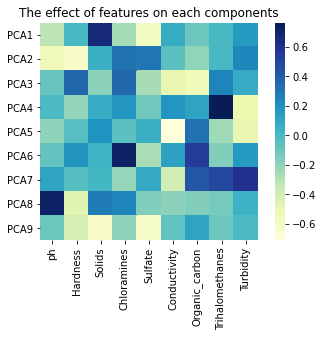

In [45]:
ax = sns.heatmap(pca.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(X_test) for X_test in range(1,pca.n_components_+1)],
                 xticklabels=list(df_features.columns),
                 cbar_kws={"orientation": "vertical"})
plt.yticks(rotation=0) 
ax.set_aspect("equal")
plt.title('The effect of features on each components')

<BarContainer object of 9 artists>

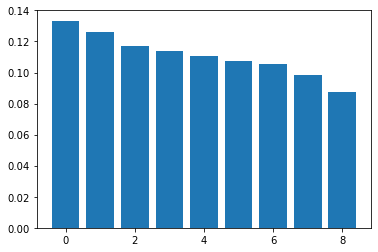

In [46]:
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)

We don't see any major components here: all have an explain variance of approximately 0.11.\
Then all features seem equally important.

Now we can try to visualize the data:

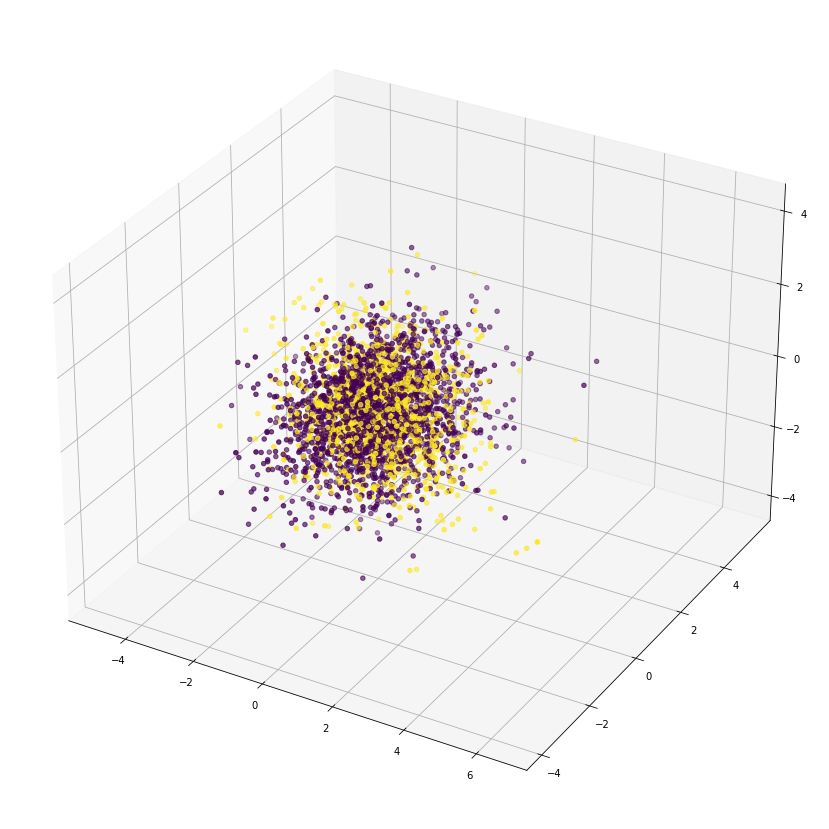

In [47]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
# the points color depends on their label
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=y)
plt.show()

We don't see anything convincing with PCA.\
Let's try discriminant analysis:

In [48]:
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)
pd.DataFrame(lda.coef_.T, index=list(df_features.columns))
X_res = X - X_lda.dot(lda.coef_)
ldpca = PCA()
X_ldpca = ldpca.fit_transform(X_res)

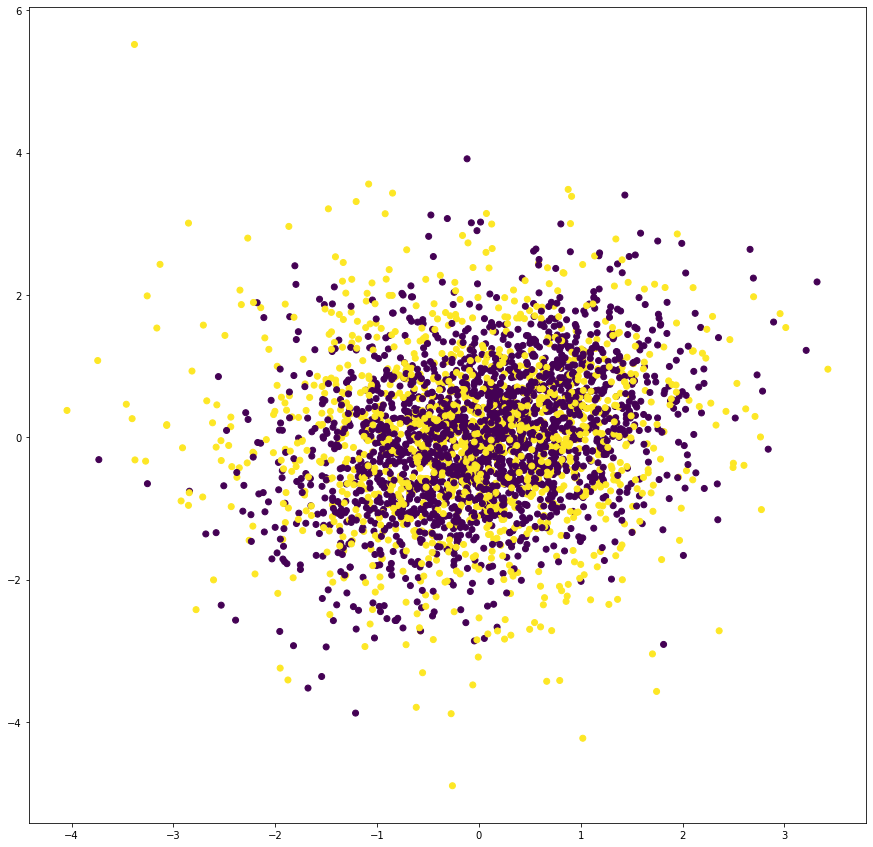

In [49]:
fig = plt.figure(figsize=(15, 15))
plt.scatter(X_lda[:,0], X_ldpca[:,1], c=y)
plt.show()

We still don't manage to see anything.

### Clusterization

We may try to better understand how data are represented by grouping them into clusters.

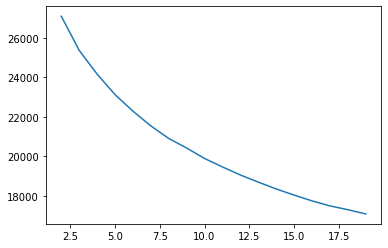

In [50]:
inertia = []

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)


plt.plot(range(2, 20), inertia)

In [51]:
k = 6

kmeans = KMeans(n_clusters=k)
y_clusters = kmeans.fit_predict(X)
pd.Series(y_clusters).value_counts()

2    612
5    596
1    587
3    544
0    522
4    415
dtype: int64

In [52]:
def show_stat_clusters(stat):
  series_clusters = []

  for i in range(k):
    df_stats_i = df_features[y_clusters == i].describe()
    series_clusters.append(df_stats_i.loc[stat, :].rename("Cluster {}".format(i)))
  return pd.concat(series_clusters, axis=1)

In [53]:
show_stat_clusters("mean")

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
ph,6.545802,6.887401,6.588936,7.377544,6.955681,8.025976
Hardness,191.547941,188.976192,194.939172,211.511260,166.479202,216.334986
Solids,34897.332165,20028.253825,19909.147597,20471.262931,19866.105296,17751.637028
Chloramines,6.958903,6.907100,7.692855,6.291472,7.666752,7.270594
Sulfate,303.916906,331.832234,320.531462,332.980607,385.588704,331.989055
Conductivity,426.993642,527.797225,378.819972,395.848160,401.323890,419.147071
Organic_carbon,14.828109,14.612180,11.701242,14.262043,14.762368,15.828600
Trihalomethanes,67.589999,68.332046,74.405372,47.649167,64.362891,74.479632
Turbidity,3.817731,4.276519,4.371674,4.082086,3.858710,3.346535


In [54]:
show_stat_clusters("std")

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
ph,1.638543,1.434955,1.385501,1.477926,1.663104,1.481893
Hardness,32.246059,29.507707,27.584673,26.500267,30.620637,28.271987
Solids,6726.272810,6345.051800,6392.967389,6826.878085,7779.730618,6298.346749
Chloramines,1.655136,1.430938,1.481837,1.434256,1.528047,1.535690
Sulfate,39.976598,32.853252,32.359704,33.325149,30.912587,31.601501
Conductivity,71.843167,53.508691,58.154874,64.952535,64.066844,67.981483
Organic_carbon,3.098762,3.002295,2.833826,3.150548,3.106815,3.025559
Trihalomethanes,13.321104,14.074430,13.507432,11.924452,14.073127,12.807863
Turbidity,0.746786,0.687711,0.701133,0.725139,0.694172,0.624129


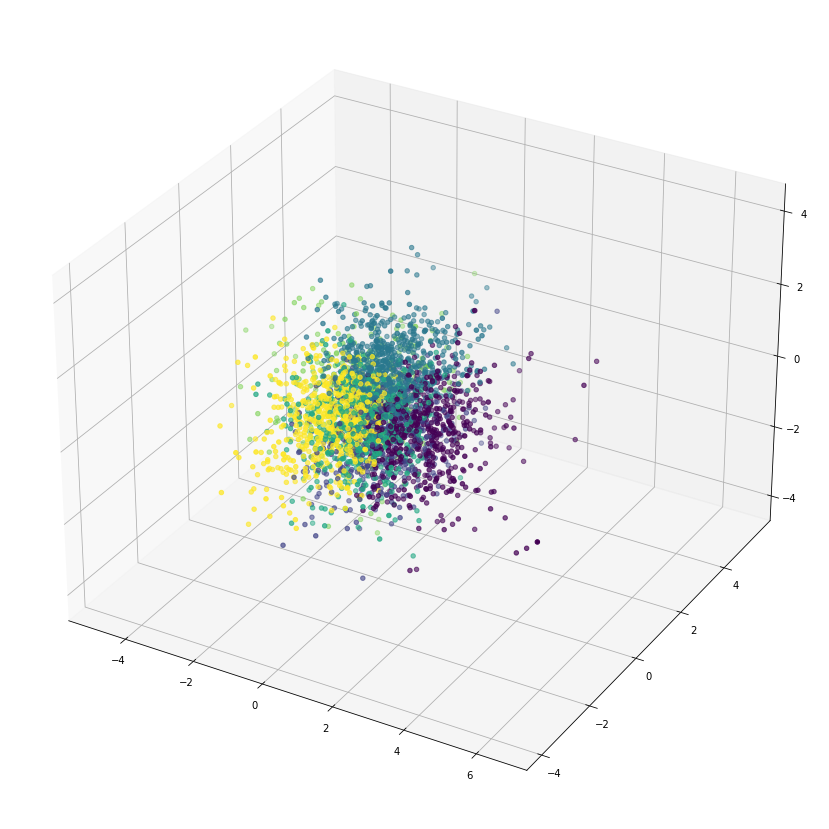

In [55]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
# the points color depends on their label
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=y_clusters)
plt.show()

No real cluster seems to appear, kmeans only takes random part of the data.\
We can retry with spectral clustering:

In [56]:
k = 6

kmeans = SpectralClustering(n_clusters=k)
y_clusters = kmeans.fit_predict(X)
pd.Series(y_clusters).value_counts()

0    3259
4       4
5       4
2       3
1       3
3       3
dtype: int64

In [57]:
show_stat_clusters("mean")

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
ph,7.075688,9.271579,6.793968,8.649088,8.441406,8.141335
Hardness,196.454422,277.826258,250.652848,123.200696,157.606859,119.010188
Solids,21940.787686,43441.571177,8077.963139,42923.250270,51992.273922,30460.649530
Chloramines,7.125528,7.966234,9.917576,5.904728,4.243952,5.535312
Sulfate,333.916423,246.801767,230.560713,433.399078,217.307954,431.037438
Conductivity,426.133434,515.895301,368.822341,342.776350,465.626102,483.523900
Organic_carbon,14.287209,15.052577,13.831822,11.332226,11.972308,16.752568
Trihalomethanes,66.413491,62.842715,44.644049,62.774125,57.735999,81.267369
Turbidity,3.967888,3.931774,2.691153,4.424668,3.538219,4.137526


In [58]:
show_stat_clusters("std")

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
ph,1.595028,NaN,1.078698,0.939572,0.966405,0.675583
Hardness,32.586169,7.263499,20.560544,9.064661,40.254517,9.006275
Solids,8662.532730,4127.101359,1370.520299,2804.696492,5159.488360,2963.432626
Chloramines,1.579676,0.491213,0.131515,0.675855,0.721869,0.698364
Sulfate,40.610052,14.558135,16.614375,14.518568,62.264678,34.064951
Conductivity,80.819032,37.192789,54.896275,77.196294,62.432940,48.408040
Organic_carbon,3.311763,0.812518,1.534039,1.306205,1.836029,2.199572
Trihalomethanes,16.179227,10.949172,8.660004,11.323949,14.765591,4.964208
Turbidity,0.780544,0.330970,0.148547,0.187448,0.861558,0.447419


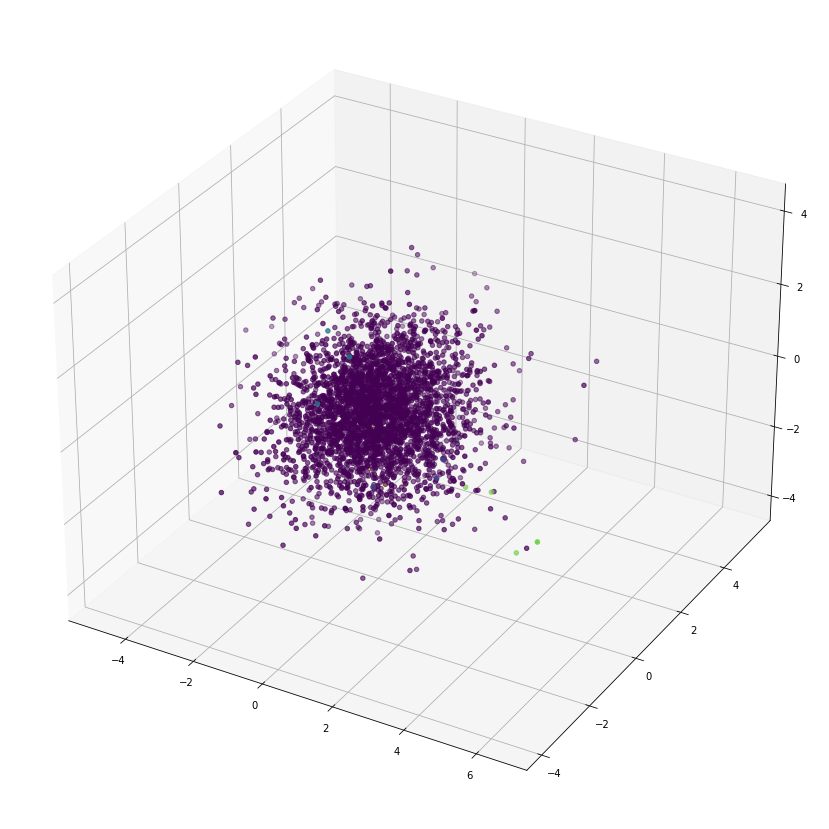

In [59]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
# the points color depends on their label
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=y_clusters)
plt.show()

We see here that spectral clustering doesn't manage to get any cluster.

## Bonus: rule based algorithm

We will try here to see if a classification algorithm based of the WHO rules would perform well.

In [60]:
y_corrected = df_corrected["Potability"]
y_pred = np.zeros(df_corrected.shape[0])
y_pred[(df_corrected["ph"] >= 6.5) & (df_corrected["ph"] <= 8.5) &
        (df_corrected["Conductivity"] <= 400) &
        (df_corrected["Trihalomethanes"] <= 80) &
        (df_corrected["Turbidity"] <= 5)] = 1
sum(y_pred)

362.0

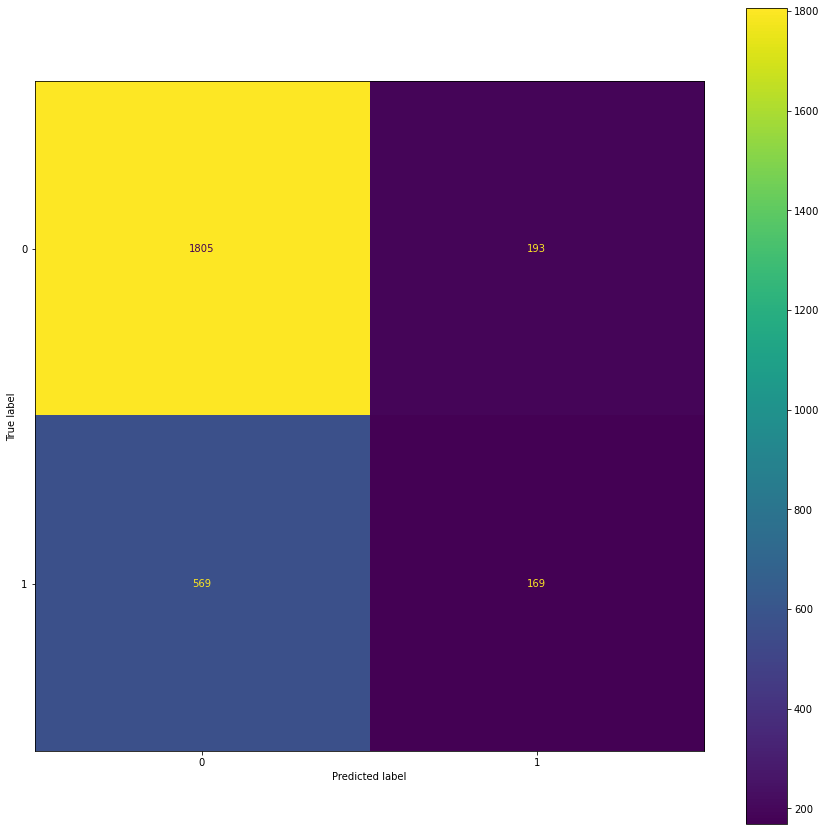

In [61]:
fig, ax = plt.subplots(figsize=(15, 15))
cm = confusion_matrix(y_corrected, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0, 1])
disp.plot(ax=ax)

As we can see here, this model isn't a good classifier. As we could guess, it isn't as easy to guess if the sources are potable.

## Conclusion

Observations:
- There are some weird values in the dataset, according to WHO (undrinkable water that is labeled as drinkable).
- All features are continuous. 
- They don't seem to be correlated.
- They aren't capped.
- It seems that no outliers (other than the ones we cited before) must be deleted.
- Their scales are quite different.
- Some values are missing in some features (MCAR).
- The dataset is also slightly unbalanced.

In the preprocessing, we will then have to
- Filter out or scale sources marked as drinkable but that aren't
- (Optional) transform features with big variance using a power transform
- Rescale the features (avg=0, std=1)
- Delete or complete rows with missing values
- Create the training, validation and test sets while being carreful to keep the correct distribution of the labels.